In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Siamese/Place'

/content/drive/My Drive/Siamese/Place


In [ ]:
import sys
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')
sys.path.insert(0, '../Speaker')
sys.path.insert(0, '../Conference')
sys.path.insert(0, '..')

In [ ]:
!pip install torchaudio

     |████████████████████████████████| 3.2MB 2.7MB/s 


In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [ ]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 6

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [ ]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType
from torchvision.transforms import Compose

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  2134


In [ ]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Conference(DEVICE, time=False)
net.to(DEVICE)

Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [ ]:
with torch.no_grad():
  # test
  net.eval()
  # Store the places
  speakers_list = testset.get_speakers_list(10)
  net.load_encoder()
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list, maxsize=3)

Encoder loaded


In [ ]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []
  final_mean_accuracies = []
  final_min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    final_mean_accuracy = 0
    final_min_accuracy = 0
    nb_test = 0

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      final_mean_label, final_min_label = net(sample, place_id=gold_label)
      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1
      if gold_label == final_mean_label:
        final_mean_accuracy += 1
      if gold_label == final_min_label:
        final_min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    final_mean_accuracy /= nb_test
    final_min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    final_mean_accuracies.append(final_mean_accuracy)
    final_min_accuracies.append(final_min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    print("accuracy final_mean ", final_mean_accuracy, 
          " final_min ", final_min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)

*** Epoch  0  ***


2134it [05:23,  6.60it/s]

accuracy mean  0.5121836925960638 topk 0.6682286785379569  min  0.704311152764761
accuracy final_mean  0.8013120899718837  final_min  0.7638238050609185
Error  0.33177132146204313
{270: 10, 272: 40, 273: 47, 274: 24, 275: 100, 276: 8, 277: 26, 278: 13, 271: 21, 279: 80, 280: 73, 281: 64, 282: 32, 283: 36, 285: 75, 284: 2, 286: 2, 287: 66, 288: 33, 289: 9}
*** Epoch  1  ***



2134it [01:08, 31.19it/s]

accuracy mean  0.6757263355201499 topk 0.7680412371134021  min  0.7492970946579194
accuracy final_mean  0.9404873477038426  final_min  0.8697282099343955
Error  0.23195876288659795
{270: 17, 272: 40, 273: 38, 274: 16, 275: 29, 276: 14, 277: 26, 278: 4, 271: 12, 279: 38, 280: 37, 281: 32, 282: 27, 283: 35, 285: 36, 284: 2, 286: 2, 287: 43, 288: 16, 289: 13}
*** Epoch  2  ***



2134it [01:08, 31.08it/s]

accuracy mean  0.7286785379568884 topk 0.7582005623242737  min  0.7525773195876289
accuracy final_mean  0.9479850046860356  final_min  0.865979381443299
Error  0.24179943767572634
{270: 21, 272: 48, 273: 46, 274: 18, 275: 12, 276: 15, 277: 31, 278: 5, 271: 13, 279: 26, 280: 38, 281: 36, 282: 25, 283: 37, 285: 32, 284: 2, 286: 2, 287: 39, 288: 18, 289: 13}
*** Epoch  3  ***



2134it [01:08, 31.02it/s]

accuracy mean  0.7057169634489222 topk 0.7502343017806935  min  0.7488284910965324
accuracy final_mean  0.9432989690721649  final_min  0.8598875351452671
Error  0.24976569821930647
{270: 22, 272: 54, 273: 50, 274: 18, 275: 10, 276: 15, 277: 31, 278: 8, 271: 17, 279: 25, 280: 37, 281: 35, 282: 23, 283: 37, 285: 36, 284: 2, 286: 2, 287: 39, 288: 16, 289: 13}
*** Epoch  4  ***



2134it [01:08, 31.01it/s]

accuracy mean  0.6986879100281163 topk 0.7422680412371134  min  0.7483598875351453
accuracy final_mean  0.9372071227741331  final_min  0.8556701030927835
Error  0.25773195876288657
{270: 27, 272: 56, 273: 50, 274: 18, 275: 12, 276: 15, 277: 35, 278: 5, 271: 13, 279: 31, 280: 38, 281: 36, 282: 23, 283: 37, 285: 35, 284: 3, 286: 2, 287: 39, 288: 22, 289: 12}
*** Epoch  5  ***



2134it [01:08, 30.97it/s]


accuracy mean  0.7029053420805998 topk 0.739456419868791  min  0.7417994376757263
accuracy final_mean  0.9358013120899719  final_min  0.85941893158388
Error  0.260543580131209
{270: 28, 272: 56, 273: 52, 274: 22, 275: 12, 276: 15, 277: 35, 278: 6, 271: 15, 279: 26, 280: 43, 281: 35, 282: 23, 283: 35, 285: 37, 284: 2, 286: 2, 287: 45, 288: 16, 289: 13}


In [ ]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))
print("maximum of final mean", round(np.max(final_mean_accuracies), 3))
print("maximum of final min", round(np.max(final_mean_accuracies), 3))

maximum of min 0.753
maximum of topk 0.768
maximum of mean 0.729
maximum of final mean 0.948
maximum of final min 0.948


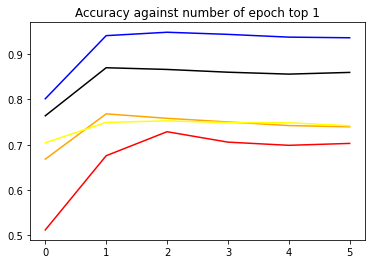

In [ ]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='orange')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='yellow')
plt.plot([i for i in range(EPOCH_NUM)], final_mean_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], final_min_accuracies , label='test 1', color='black')

In [ ]:
import numpy as np
import torch as th

with torch.no_grad():
  min_accuracies = []
  mean_accuracies = []
  
  for epoch_num in range(1):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    min_accuracy = 0
    nb_test = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, min_label = net.forward(sample, place_id=gold_label)
      nb_test += 1
      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "min", min_accuracy)


*** Epoch  0  ***


2134it [00:34, 62.33it/s]

accuracy mean  0.9329896907216495 min 0.8561387066541706
